### Lesson 7 Assignment - Age of Abalone
### Lawrence Huang
##### Instructions

Using the Abalone csv file, create a new notebook to build an experiment using support vector machine classifier and regression. Perform each of the following tasks and answer the questions:

1. Convert the continuous output value from continuous to binary (0,1) and build an SVC
2. Using your best guess for hyperparameters and kernel, what is the percentage of correctly classified results?
3. Test different kernels and hyperparameters or consider using sklearn.model_selection.SearchGridCV. Which kernel performed best with what settings?
4. Show recall, precision and f-measure for the best model
5. Using the original data, with rings as a continuous variable, create an SVR model
6. Report on the predicted variance and the mean squared error

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
# load dataset
fn = 'https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Abalone.csv'
df = pd.read_csv(fn)
# preview data
print('dataset shape:{}'.format(df.shape))
df.head()

dataset shape:(4177, 9)


,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
# view data info: all columns numeric except Sex
print(df.info())

# per data source, original data examples with missing values were removed
# confirmed no missing numeric values
print('\nMissing values by column:\n{}'.format(df.isna().sum()))

# confirmed no missing values in Sex
print('\nDistribution of Sex:\n{}'.format(df['Sex'].value_counts()))
print('Total: {}'.format(df['Sex'].value_counts().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole Weight      4177 non-null float64
Shucked Weight    4177 non-null float64
Viscera Weight    4177 non-null float64
Shell Weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None

Missing values by column:
Sex               0
Length            0
Diameter          0
Height            0
Whole Weight      0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Rings             0
dtype: int64

Distribution of Sex:
M    1528
I    1342
F    1307
Name: Sex, dtype: int64
Total: 4177


In [4]:
# view number of unique values/levels
print('# unique values/levels:\n{}'.format(df.nunique()))

# unique values/levels:
Sex                  3
Length             134
Diameter           111
Height              51
Whole Weight      2429
Shucked Weight    1515
Viscera Weight     880
Shell Weight       926
Rings               28
dtype: int64


In [5]:
# Per data source, the ranges of the continuous values have been scaled (by dividing by 200) for use with machine learning algorithms such as SVMs
# confirm features are on the same scale
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
num_cols = [xx for xx in num_cols if xx != 'Rings']
df[num_cols].describe().loc[['mean', 'std', 'min', 'max'],:]

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


##### 1. Convert the continuous output value from continuous to binary (0,1) and build an SVC
Per instructions: Target = Rings. Assign samples that are younger than 11 years old to class: 0 and those that are older to class: 1

In [6]:
# convert Rings to binary
# 77/23 class distribution. Will keep an eye on the classification results as there is class imbalance
df['Class'] = pd.cut(df['Rings'], bins=[0, 11, np.max(df['Rings'])], labels=[0, 1], include_lowest=True)
print('Bin distribution:\n{}'.format(df['Class'].value_counts()))
print('\nBin distribution (%):\n{}'.format(df['Class'].value_counts()/len(df['Class'])))
print('\nTotal observations after binning: {}'.format(df['Class'].value_counts().sum()))

Bin distribution:
0    3217
1     960
Name: Class, dtype: int64

Bin distribution (%):
0    0.77017
1    0.22983
Name: Class, dtype: float64

Total observations after binning: 4177


##### Results (1):
Continuous output variable Rings was coverted to binary variable Class for use with SVC.

In [7]:
# one hot encode categorical columns
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)

# preview data
print('\ndataset shape after one hot encoding:{}'.format(df.shape))
df.head()


dataset shape after one hot encoding:(4177, 11)


,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings,Class,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


In [8]:
# train/test split
y = df['Class'] # label
X = df.loc[:, ~df.columns.isin(['Class', 'Rings'])] # features, use all but the target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)
print('features:\n{}'.format(X.columns.values))
print('\n# features: {}'.format(len(X.columns.values)))

features:
['Length' 'Diameter' 'Height' 'Whole Weight' 'Shucked Weight'
 'Viscera Weight' 'Shell Weight' 'Sex_I' 'Sex_M']

# features: 9


##### 2. Using your best guess for hyperparameters and kernel, what is the percentage of correctly classified results?

In [9]:
# initial guess for hyperparameters and kernel
cost = 10 # penalty parameter of the error term
gamma = 0.2 # defines the influence of input vectors on the margins

clf = SVC(C=cost, kernel='rbf', gamma=gamma, random_state=5).fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)

# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_clf)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_clf).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_clf))


Confusion Matrix:
[[618  26]
 [115  77]]

TP, TN, FP, FN: 77 , 618 , 26 , 115

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       644
           1       0.75      0.40      0.52       192

    accuracy                           0.83       836
   macro avg       0.80      0.68      0.71       836
weighted avg       0.82      0.83      0.81       836



##### Results (2): 
Using initial kernel and hyperparameter guesses (kernel=rbf, C=10 and gamma=0.2), accuracy was 0.83. However, f1-score (and in particular recall) for Class 1 was low.

##### 3. Test different kernels and hyperparameters or consider using sklearn.model_selection.SearchGridCV. Which kernel performed best with what settings?

In [10]:
# grid search parameters
parameters = [
    {'C': [1e1, 1e2, 1e3, 1e4], 'kernel': ['poly', 'rbf'], 'gamma': [0.01, 'auto', 1, 'scale'], 'class_weight': [None, 'balanced']},
    {'C': [1e1, 1e2, 1e3, 1e4], 'kernel': ['linear'], 'class_weight': [None, 'balanced']}
]
print('The following hyperparameters were tuned: {}\n'.format(list(parameters[0].keys())))

# grid search, fit with best estimator
gsc = GridSearchCV(estimator=SVC(),
                      param_grid=parameters, iid=False, cv=3, scoring='accuracy', n_jobs=-1, verbose=5)
gsc.fit(X_train, y_train)

The following hyperparameters were tuned: ['C', 'kernel', 'gamma', 'class_weight']

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 12.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=-1,
             param_grid=[{'C': [10.0, 100.0, 1000.0, 10000.0],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.01, 'auto', 1, 'scale'],
                          'kernel': ['poly', 'rbf']},
                         {'C': [10.0, 100.0, 1000.0, 10000.0],
                          'class_weight': [None, 'balanced'],
                          'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=5)

In [11]:
# best tuned estimator and hyperparameters
print('Best tuned estimator:\n{}'.format(gsc.best_estimator_))
print('\nOf the hyperparameters tested, best performing kernel: {}'.format(gsc.best_params_['kernel']))
print('Best hyperparameters: {}'.format(gsc.best_params_))

Best tuned estimator:
SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Of the hyperparameters tested, best performing kernel: rbf
Best hyperparameters: {'C': 100.0, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}


##### Results (3):
The best-performing kernel and hyperparameter settings are shown in the above cell.

##### 4. Show recall, precision and f-measure for the best model

In [12]:
# prediction
y_pred_gsc = gsc.predict(X_test)

# evaluate model using confusion matrix-derived metrics
print('Tuned SVC')
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_gsc)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gsc).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_gsc))

Tuned SVC

Confusion Matrix:
[[616  28]
 [110  82]]

TP, TN, FP, FN: 82 , 616 , 28 , 110

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       644
           1       0.75      0.43      0.54       192

    accuracy                           0.83       836
   macro avg       0.80      0.69      0.72       836
weighted avg       0.82      0.83      0.82       836



##### Results (4):
Recall, precision, and f1-score for the best model are shown in the above cell.

While overall accuracy was not changed compared to the initial model, the best model produced a slight improvement in recall and f1-score for Class 1.

##### 5. Using the original data, with rings as a continuous variable, create an SVR model

In [13]:
# train/test split
y = df['Rings'] # target
X = df.loc[:, ~df.columns.isin(['Class', 'Rings'])] # features, use all but the target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
print('features:\n{}'.format(X.columns.values))
print('\n# features: {}'.format(len(X.columns.values)))

features:
['Length' 'Diameter' 'Height' 'Whole Weight' 'Shucked Weight'
 'Viscera Weight' 'Shell Weight' 'Sex_I' 'Sex_M']

# features: 9


In [14]:
# initial guess for hyperparameters and kernel
cost = 100 # penalty parameter of the error term
gamma = 0.2 # defines the influence of input vectors on the margins
regressor = SVR(C=cost, kernel='rbf', gamma=gamma).fit(X_train, y_train)
print('SVR model:\n{}'.format(regressor))

SVR model:
SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.2,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


##### 6. Report on the predicted variance and the mean squared error

In [15]:
# prediction
y_pred_regressor = regressor.predict(X_test) # test set
y_pred_regressor_train = regressor.predict(X_train) # train set

# compute R2, adjusted R2 for model using train set
ntrain = X_train.shape[0]
ptrain = X_train.shape[1]
R2_regressor_train = r2_score(y_train, y_pred_regressor_train)
adjR2_regressor_train = 1-(1-R2_regressor_train)*(ntrain-1)/(ntrain-ptrain-1)

# MSE on test set
MSE_regressor = mean_squared_error(y_test, y_pred_regressor)

print('Initial SVR model:')
print('\nModel explained variance (R2 train): {:.3f}'.format(R2_regressor_train))
print('Adjusted R2 train: {:.3f}'.format(adjR2_regressor_train))
print('\nMSE test: {:.3f}'.format(MSE_regressor))

Initial SVR model:

Model explained variance (R2 train): 0.575
Adjusted R2 train: 0.574

MSE test: 4.881


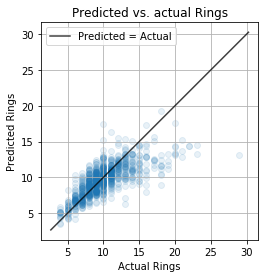

In [16]:
# visualize predicted vs. actual Rings
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_regressor, alpha=0.1)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=10, label='Predicted = Actual')
ax.set_xlabel('Actual Rings')
ax.set_ylabel('Predicted Rings')
ax.set_title('Predicted vs. actual Rings')
ax.set_aspect('equal')
ax.legend()
ax.grid()
plt.show()

##### Try tuning SVR hyperparameters

In [17]:
# grid search parameters
parameters = [
    {'C': [1e1, 1e2, 1e3, 1e4], 'kernel': ['poly', 'rbf'], 'gamma': [0.01, 'auto', 1, 'scale'], 'epsilon': [0.01, 0.1, 1, 2, 5]},
    {'C': [1e1, 1e2, 1e3, 1e4], 'kernel': ['linear'], 'epsilon': [0.01, 0.1, 1, 2, 5]}
]
print('The following hyperparameters were tuned:\n{}'.format(list(parameters[0].keys())))

# grid search, fit with best estimator
gsr = GridSearchCV(estimator=SVR(),
                      param_grid=parameters, iid=False, cv=3, n_jobs=-1, verbose=5)
gsr.fit(X_train, y_train)

The following hyperparameters were tuned:
['C', 'kernel', 'gamma', 'epsilon']
Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 382 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 65.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid=False, n_jobs=-1,
             param_grid=[{'C': [10.0, 100.0, 1000.0, 10000.0],
                          'epsilon': [0.01, 0.1, 1, 2, 5],
                          'gamma': [0.01, 'auto', 1, 'scale'],
                          'kernel': ['poly', 'rbf']},
                         {'C': [10.0, 100.0, 1000.0, 10000.0],
                          'epsilon': [0.01, 0.1, 1, 2, 5],
                          'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [18]:
# best tuned estimator and hyperparameters
print('Best tuned estimator:\n{}'.format(gsr.best_estimator_))
print('\nOf the hyperparameters tested, best performing kernel: {}'.format(gsr.best_params_['kernel']))
print('Best hyperparameters: {}'.format(gsr.best_params_))

Best tuned estimator:
SVR(C=10000.0, cache_size=200, coef0=0.0, degree=3, epsilon=2, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Of the hyperparameters tested, best performing kernel: rbf
Best hyperparameters: {'C': 10000.0, 'epsilon': 2, 'gamma': 'auto', 'kernel': 'rbf'}


In [19]:
# prediction
y_pred_gsr = gsr.predict(X_test) # test set
y_pred_gsr_train = gsr.predict(X_train) # train set

# compute R2, adjusted R2 for model using train set
ntrain = X_train.shape[0]
ptrain = X_train.shape[1]
R2_gsr_train = r2_score(y_train, y_pred_gsr_train)
adjR2_gsr_train = 1-(1-R2_gsr_train)*(ntrain-1)/(ntrain-ptrain-1)

# MSE on test set
MSE_gsr = mean_squared_error(y_test, y_pred_gsr)

print('Tuned SVR model:')
print('\nModel explained variance (R2 train): {:.3f}'.format(R2_gsr_train))
print('Adjusted R2 train: {:.3f}'.format(adjR2_gsr_train))
print('\nMSE test: {:.3f}'.format(MSE_gsr))

Tuned SVR model:

Model explained variance (R2 train): 0.598
Adjusted R2 train: 0.596

MSE test: 4.760


In [20]:
print('Using SVR with initial kernel and hyperparameter guesses: kernel={}, C={:.0f}, gamma={}, epsilon={}:'.format(
    regressor.kernel, regressor.C, regressor.gamma, regressor.epsilon))
print('Model explained variance/R2 was {:.3f} and MSE test was {:.3f}'.format(
    R2_regressor_train, MSE_regressor))

print('\nUsing a tuned SVR with: kernel={}, C={:.0f}, gamma={}, epsilon={}:'.format(
    gsr.best_estimator_.kernel, gsr.best_estimator_.C, gsr.best_estimator_.gamma, gsr.best_estimator_.epsilon))
print('Model explained variance/R2 was {:.3f} and MSE test was {:.3f}'.format(
    R2_gsr_train, MSE_gsr))


Using SVR with initial kernel and hyperparameter guesses: kernel=rbf, C=100, gamma=0.2, epsilon=0.1:
Model explained variance/R2 was 0.575 and MSE test was 4.881

Using a tuned SVR with: kernel=rbf, C=10000, gamma=auto, epsilon=2:
Model explained variance/R2 was 0.598 and MSE test was 4.760


##### Results (5, 6):
Results are shown in the above cell. A SVR model was constructed to predict the continuous target Rings. Tuning the SVR slightly increased explained variance and slightly decreased MSE.